<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_25_Drop_Adam_All_B64_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio

In [ ]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [ ]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_X

array([[[[ 54,  65,  81],
         [ 51,  60,  77],
         [ 38,  50,  71],
         ...,
         [ 70,  93, 106],
         [ 66,  87, 105],
         [ 60,  82, 105]],

        [[ 59,  67,  81],
         [ 54,  63,  78],
         [ 52,  60,  77],
         ...,
         [ 75,  91, 103],
         [ 78,  95, 108],
         [ 71,  87, 105]],

        [[ 76,  82,  98],
         [ 73,  80,  96],
         [ 55,  64,  82],
         ...,
         [ 75,  94, 107],
         [ 75,  95, 106],
         [ 80, 100, 111]],

        ...,

        [[ 61,  64,  72],
         [ 64,  65,  73],
         [ 68,  71,  79],
         ...,
         [ 71,  83, 101],
         [ 67,  81,  95],
         [ 68,  86, 102]],

        [[ 50,  51,  54],
         [ 52,  50,  54],
         [ 63,  60,  64],
         ...,
         [ 68,  80,  97],
         [ 81,  96, 106],
         [ 69,  87, 103]],

        [[ 51,  50,  53],
         [ 51,  49,  50],
         [ 62,  61,  64],
         ...,
         [ 68,  86,  99],
        

In [ ]:
train_Y

,0
0,Sugar beet
1,Sugar beet
2,Sugar beet
3,Sugar beet
4,Sugar beet
...,...
4745,Small-flowered Cranesbill
4746,Small-flowered Cranesbill
4747,Small-flowered Cranesbill
4748,Small-flowered Cranesbill


In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3325, 224, 224, 3), (1425, 224, 224, 3))



**Image** Normalization




In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [ ]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.25103759765625 MB


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
52/52 [==============================] - 149s 3s/step - loss: 2.2033 - accuracy: 0.2562 - val_loss: 1.9702 - val_accuracy: 0.3754
Epoch 2/25
52/52 [==============================] - 147s 3s/step - loss: 1.8508 - accuracy: 0.3868 - val_loss: 1.7363 - val_accuracy: 0.4070
Epoch 3/25
52/52 [==============================] - 147s 3s/step - loss: 1.6833 - accuracy: 0.4367 - val_loss: 1.6537 - val_accuracy: 0.4175
Epoch 4/25
52/52 [==============================] - 148s 3s/step - loss: 1.5525 - accuracy: 0.4806 - val_loss: 1.5010 - val_accuracy: 0.4870
Epoch 5/25
52/52 [==============================] - 147s 3s/step - loss: 1.4471 - accuracy: 0.5257 - val_loss: 1.4074 - val_accuracy: 0.5319
Epoch 6/25
52/52 [==============================] - 148s 3s/step - loss: 1.3696 - accuracy: 0.5501 - val_loss: 1.3940 - val_accuracy: 0.5144
Epoch 7/25
52/52 [==============================] - 147s 3s/step - loss: 1.3077 - accuracy: 0.5606 - val_loss: 1.2677 - val_accuracy: 0.5811
Epoch 8/25
52

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

62.37030792236328 MB


In [ ]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

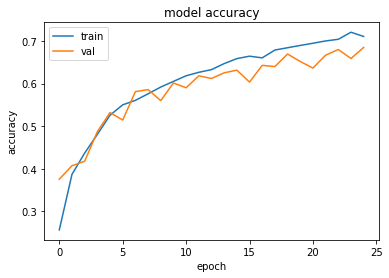

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

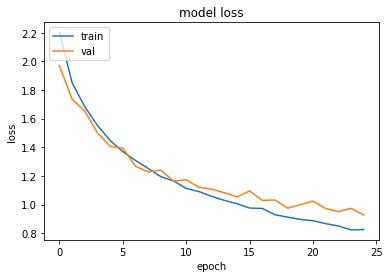

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

104/104 [==============================] - 104s 999ms/step - loss: 0.7525 - accuracy: 0.7543
Test loss: 0.9277951121330261    Test accuracy: 0.6849122643470764
Train loss: 0.7525230646133423    Train accuracy: 0.7542856931686401


## Resnet 50

In [ ]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.0436248779297 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
52/52 [==============================] - 175s 3s/step - loss: 1.1325 - accuracy: 0.6262 - val_loss: 0.6676 - val_accuracy: 0.7796
Epoch 2/25
52/52 [==============================] - 168s 3s/step - loss: 0.4611 - accuracy: 0.8415 - val_loss: 0.5364 - val_accuracy: 0.8274
Epoch 3/25
52/52 [==============================] - 169s 3s/step - loss: 0.3536 - accuracy: 0.8740 - val_loss: 0.5359 - val_accuracy: 0.8196
Epoch 4/25
52/52 [==============================] - 171s 3s/step - loss: 0.2235 - accuracy: 0.9293 - val_loss: 0.5325 - val_accuracy: 0.8225
Epoch 5/25
52/52 [==============================] - 170s 3s/step - loss: 0.1772 - accuracy: 0.9441 - val_loss: 0.5219 - val_accuracy: 0.8267
Epoch 6/25
52/52 [==============================] - 170s 3s/step - loss: 0.1384 - accuracy: 0.9564 - val_loss: 0.5096 - val_accuracy: 0.8449
Epoch 7/25
52/52 [==============================] - 170s 3s/step - loss: 0.1056 - accuracy: 0.9696 - val_loss: 0.4671 - val_accuracy: 0.8491
Epoch 8/25
52

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

248.15567016601562 MB


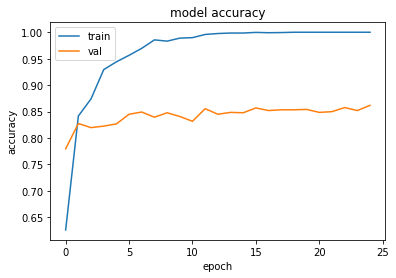

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


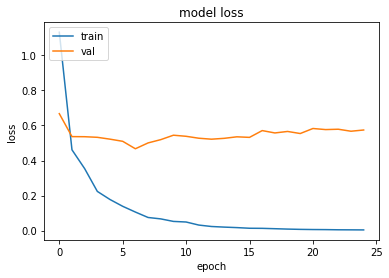

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 103s 990ms/step - loss: 0.0018 - accuracy: 1.0000
Test loss: 0.5742000937461853    Test accuracy: 0.8617543578147888
Train loss: 0.001844218815676868    Train accuracy: 1.0


## INCEPTION V3

In [ ]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.0603256225586 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 38s 656ms/step - loss: 1.5518 - accuracy: 0.5155 - val_loss: 0.8990 - val_accuracy: 0.6954
Epoch 2/25
52/52 [==============================] - 32s 621ms/step - loss: 0.7129 - accuracy: 0.7495 - val_loss: 0.7427 - val_accuracy: 0.7593
Epoch 3/25
52/52 [==============================] - 32s 627ms/step - loss: 0.5493 - accuracy: 0.8102 - val_loss: 0.6624 - val_accuracy: 0.7860
Epoch 4/25
52/52 [==============================] - 33s 636ms/step - loss: 0.4296 - accuracy: 0.8502 - val_loss: 0.6761 - val_accuracy: 0.7712
Epoch 5/25
52/52 [==============================] - 33s 632ms/step - loss: 0.3576 - accuracy: 0.8773 - val_loss: 0.6183 - val_accuracy: 0.8063
Epoch 6/25
52/52 [==============================] - 33s 634ms/step - loss: 0.3047 - accuracy: 0.8944 - val_loss: 0.6319 - val_accuracy: 0.7839
Epoch 7/25
52/52 [==============================] - 33s 636ms/step - loss: 0.2441 - accuracy: 0.9239 - val_loss: 0.6283 - val_accuracy: 0.8056

In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



108.17230224609375 MB


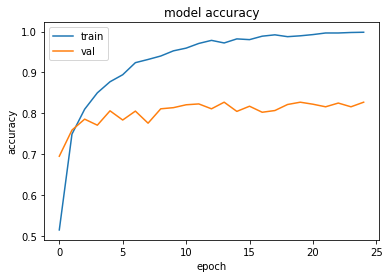

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


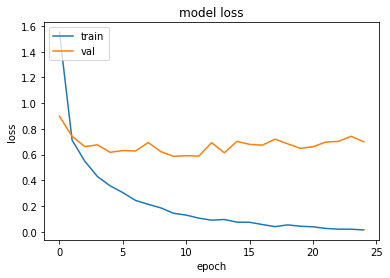

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 22s 211ms/step - loss: 0.0054 - accuracy: 1.0000
Test loss: 0.6995069980621338    Test accuracy: 0.827368438243866
Train loss: 0.005425009876489639    Train accuracy: 1.0


## XCEPTION

In [ ]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02407836914062 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 87s 2s/step - loss: 1.2691 - accuracy: 0.5850 - val_loss: 0.8420 - val_accuracy: 0.7228
Epoch 2/25
52/52 [==============================] - 84s 2s/step - loss: 0.6622 - accuracy: 0.7729 - val_loss: 0.7347 - val_accuracy: 0.7467
Epoch 3/25
52/52 [==============================] - 85s 2s/step - loss: 0.4895 - accuracy: 0.8388 - val_loss: 0.7232 - val_accuracy: 0.7523
Epoch 4/25
52/52 [==============================] - 85s 2s/step - loss: 0.3938 - accuracy: 0.8668 - val_loss: 0.6658 - val_accuracy: 0.7747
Epoch 5/25
52/52 [==============================] - 87s 2s/step - loss: 0.3151 - accuracy: 0.8983 - val_loss: 0.6259 - val_accuracy: 0.7965
Epoch 6/25
52/52 [==============================] - 86s 2s/step - loss: 0.2495 - accuracy: 0.9287 - val_loss: 0.6183 - val_accuracy: 0.7986
Epoch 7/25
52/52 [==============================] - 86s 2s/step - loss: 0.2171 - accuracy: 0.9368 - val_loss: 0.6780 - val_accuracy: 0.7789
Epoch 8/25
52/52 [==

In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



104.13621520996094 MB


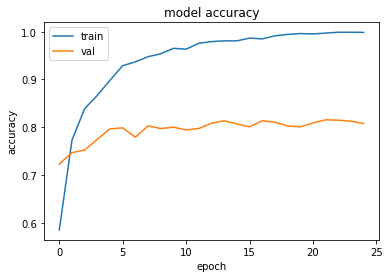

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


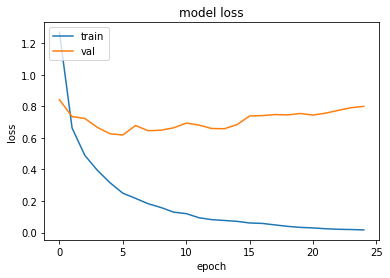

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 49s 474ms/step - loss: 0.0120 - accuracy: 0.9991
Test loss: 0.7994105219841003    Test accuracy: 0.8077192902565002
Train loss: 0.01201132033020258    Train accuracy: 0.9990977644920349


## **DenseNet121**

In [ ]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.02588653564453 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 94s 2s/step - loss: 1.3597 - accuracy: 0.5609 - val_loss: 0.8398 - val_accuracy: 0.7425
Epoch 2/25
52/52 [==============================] - 86s 2s/step - loss: 0.7050 - accuracy: 0.7687 - val_loss: 0.6385 - val_accuracy: 0.7867
Epoch 3/25
52/52 [==============================] - 87s 2s/step - loss: 0.5557 - accuracy: 0.8150 - val_loss: 0.5756 - val_accuracy: 0.8140
Epoch 4/25
52/52 [==============================] - 87s 2s/step - loss: 0.4383 - accuracy: 0.8559 - val_loss: 0.5305 - val_accuracy: 0.8239
Epoch 5/25
52/52 [==============================] - 87s 2s/step - loss: 0.3877 - accuracy: 0.8701 - val_loss: 0.4686 - val_accuracy: 0.8435
Epoch 6/25
52/52 [==============================] - 87s 2s/step - loss: 0.3583 - accuracy: 0.8734 - val_loss: 0.4772 - val_accuracy: 0.8428
Epoch 7/25
52/52 [==============================] - 87s 2s/step - loss: 0.2959 - accuracy: 0.9050 - val_loss: 0.4387 - val_accuracy: 0.8498
Epoch 8/25
52/52 [==

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



40.13800048828125 MB


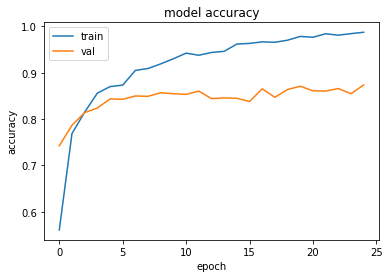

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


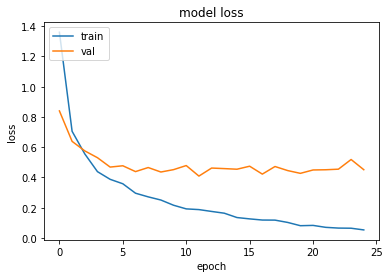

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 52s 497ms/step - loss: 0.0370 - accuracy: 0.9940
Test loss: 0.4512733817100525    Test accuracy: 0.8736842274665833
Train loss: 0.03700476512312889    Train accuracy: 0.9939849376678467


### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125572204589844 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 29s 505ms/step - loss: 1.4291 - accuracy: 0.5570 - val_loss: 0.7050 - val_accuracy: 0.7747
Epoch 2/25
52/52 [==============================] - 26s 500ms/step - loss: 0.6030 - accuracy: 0.7919 - val_loss: 0.5334 - val_accuracy: 0.8281
Epoch 3/25
52/52 [==============================] - 26s 503ms/step - loss: 0.4338 - accuracy: 0.8508 - val_loss: 0.5116 - val_accuracy: 0.8253
Epoch 4/25
52/52 [==============================] - 27s 524ms/step - loss: 0.3525 - accuracy: 0.8833 - val_loss: 0.4979 - val_accuracy: 0.8309
Epoch 5/25
52/52 [==============================] - 27s 525ms/step - loss: 0.2935 - accuracy: 0.9026 - val_loss: 0.4762 - val_accuracy: 0.8330
Epoch 6/25
52/52 [==============================] - 27s 522ms/step - loss: 0.2309 - accuracy: 0.9260 - val_loss: 0.4593 - val_accuracy: 0.8442
Epoch 7/25
52/52 [==============================] - 27s 512ms/step - loss: 0.1976 - accuracy: 0.9344 - val_loss: 0.4705 - val_accuracy: 0.8456

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



24.23772430419922 MB


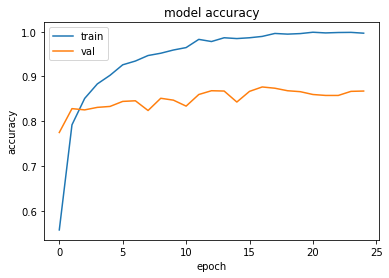

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


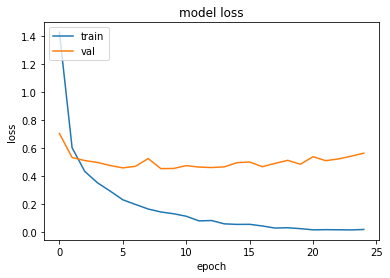

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 16s 151ms/step - loss: 0.0083 - accuracy: 1.0000
Test loss: 0.564497172832489    Test accuracy: 0.8673684000968933
Train loss: 0.00826505571603775    Train accuracy: 1.0


## **Predict train model**

In [ ]:
predictions = model.predict(X_test)

45/45 [==============================] - 9s 165ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

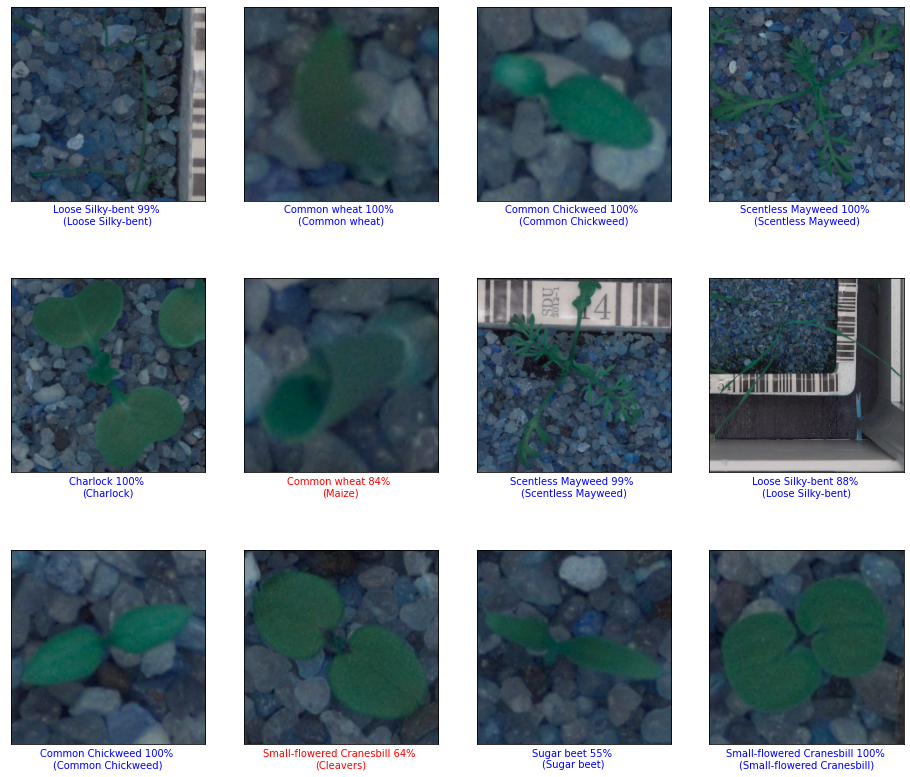

In [ ]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()